## Real Example: Geyer (Ensemble)

This notebook is an example of the usage of `tensorweave` on real FTMG data collected in Geyer, Germany. Since this trains a 100 model ensemble, it is recommended to run this on a GPU.

The authors gratefully acknowledge the <b>Federal Institute for Geosciences and Natural Resources (BGR)</b> and <b>Supracon AG</b> for providing the airborne full-tensor magnetic gradiometry dataset from Geyer, acquired in 2016 as part of the E<sup>3</sup> (ErzExploration Erzgebirge) project.

In [1]:
# Import the necessary libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cmasher as cmr
import tensorweave as tw

# Set device
device = "cuda"
dtype = torch.float32

In [2]:
# Plotting params (For an even prettier look!)
from matplotlib import colors
import matplotlib as mpl
import matplotlib.font_manager as font_manager

font_dirs = ['../additional_utils/Fonts/',]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs[0], fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Plotting params
# RCParams
import matplotlib as mpl
mpl.rcParams["text.usetex"] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams["mathtext.fontset"] = "stixsans"
plt.rcParams["mathtext.default"] = "it"
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['font.size'] = 18
plt.rcParams["axes.formatter.limits"] = [-5, 5]

# OPTIONAL CUSTOM COLORMAP
import matplotlib.colors as mcolors

# Define the colors extracted manually from the curlew
colors = [
    "#A6340B",  # rich red (not darkest)
    "#E35B0E",  # vibrant orange-red
    "#F39C12",  # medium orange
    "#F0C419",  # bright orange-yellow
    "#FAE8B6",  # soft pale orange (close to white but not pure white)
    "#8CD9E0",  # light cyan blue
    "#31B4C2",  # medium cyan-blue
    "#1B768F",  # medium blue 
    "#054862",  # deeper blue (not darkest)
]

# Create a discrete colormap using these colors
curlew_cmap = mcolors.ListedColormap(colors)
curlew_cont = mcolors.LinearSegmentedColormap.from_list(name="curlew_cont", colors=colors)

In [3]:
# Load the Geyer dataset
import joblib
geyer_dataset = joblib.load("../Datasets/geyer_dataset.pkl")

# Extract the relevant data
xyz = geyer_dataset["xyz"] # Training flight lines
xyz_all = geyer_dataset["xyz_all"] # All flight lines
xyz_test = geyer_dataset["xyz_test"] # Test flight lines
l_id = geyer_dataset["l_id"] # Training line IDs
l_id_all = geyer_dataset["l_id_all"]
l_id_test = geyer_dataset["l_id_test"]
ftg = geyer_dataset["ftg"] # Training FTG
ftg_all = geyer_dataset["ftg_all"]
ftg_test = geyer_dataset["ftg_test"]

In [4]:
# Do a quick sanity check
print(f"Training line points: {len(l_id)}")
print(f"Test line points: {len(l_id_test)}")

Training line points: 3115
Test line points: 9622


### Masks and Grids!

To get an interpolation grid, we need to mask the region of interest. We can use a concave polygon to define this region.

N.B.: This is given purely for user convenience; if the necessary packages are unavailable, it will directly import `geyer_grid.pkl`

In [5]:
# Try importing to run the masking code locally
try :
    import alphashape
    import shapely
    from sklearn.neighbors import KDTree as kdt

    # Create a concave polygon for masking the region of interest
    multipoint = xyz[:, :-1]
    alpha_value = 1.9e-3
    concave_polygon = alphashape.alphashape(multipoint, alpha_value)

    # Create a grid
    inc = 20
    padding = 300
    x_mesh = np.arange(xyz[:, 0].min() - padding, xyz[:, 0].max() + padding, inc)
    y_mesh = np.arange(xyz[:, 1].min() - padding, xyz[:, 1].max() + padding, inc)
    xx, yy = np.meshgrid(x_mesh, y_mesh)
    xvec, yvec = xx.ravel(), yy.ravel()
    zvec = 25 * np.ones_like(xvec)
    grid = np.c_[xvec, yvec, zvec]

    # Create a mask
    # First do a KDTree approach to remove most points
    known_tree = kdt(xyz[:, :-1])
    init_map_distance, _ = known_tree.query(grid[:, :-1], k=1, return_distance=True)
    init_map = (init_map_distance < 40 * inc).ravel()

    # Now only check the points that are within the concave polygon
    close_grid_points = shapely.points(grid[init_map, :-1])
    final_actv = concave_polygon.contains(close_grid_points)

    # The final mask
    actv = np.zeros_like(init_map)
    actv[init_map] = final_actv

except ImportError:
    # Load the precomputed grid
    print("Required packages for masking are not available. Loading precomputed grid instead.")
    geyer_grid = joblib.load("../Datasets/geyer_grid.pkl")

    # Extract the meshgrid from the precomputed grid
    x_mesh = geyer_grid["x_mesh"]
    y_mesh = geyer_grid["y_mesh"]
    xx = geyer_grid["xx"]
    xvec = xx.ravel()
    yy = geyer_grid["yy"]
    yvec = yy.ravel()
    # We assume a constant z value for the grid
    zvec = 25 * np.ones_like(xvec)
    grid = geyer_grid["grid"]
    actv = geyer_grid["actv"]


In [6]:
# Now only check the points that are within the concave polygon for the test lines
test_points = shapely.points(xyz_test[:, :-1])
test_actv = concave_polygon.contains(test_points)
# Final test set
xyz_test = xyz_test[test_actv, :]
ftg_test = ftg_test[test_actv, :]

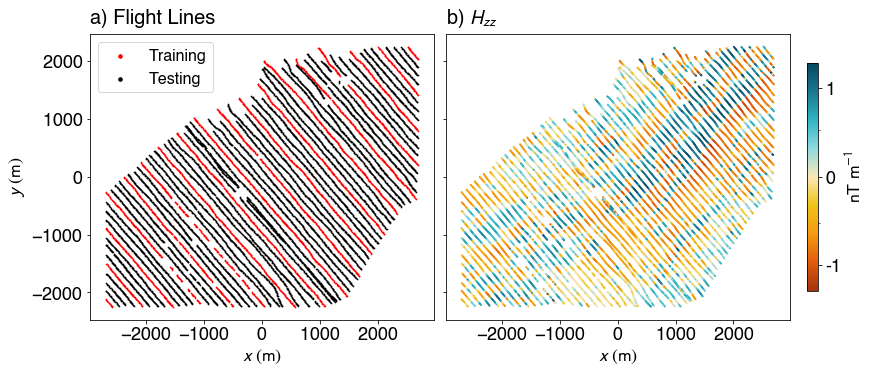

In [7]:
# Plot the flight lines
fig, ax_ = plt.subplots(1, 2, figsize=(12, 8), layout="constrained", sharex=True, sharey=True)
ax_ = ax_.ravel()

for i in range(2):
    if i == 0:
        ax = ax_[i]
        m1 = ax.scatter(xyz[:, 0], xyz[:, 1], s=0.5, c="r")
        m2 = ax.scatter(xyz_test[:, 0], xyz_test[:, 1], s=0.5, c="k")
        ax.legend([m1, m2], ["Training", "Testing"], markerscale=5, fontsize=16)
        ax.set_aspect("equal")
        ax.set_title(r"a) Flight Lines", loc="left", pad=10)
        ax.set_ylabel(r"$y\ (\mathrm{m})$")
        ax.set_xlabel(r"$x\ (\mathrm{m})$")

    elif i == 1:
        ax = ax_[i]
        ax.scatter(xyz[:, 0], xyz[:, 1], s=1, c=ftg[:, -1],
                   cmap=curlew_cont, norm=mcolors.SymLogNorm(0.1, vmin=-4, vmax=4))
        m = ax.scatter(xyz_test[:, 0], xyz_test[:, 1], s=1, c=ftg_test[:, -1],
                       cmap=curlew_cont, norm=mcolors.SymLogNorm(0.1, vmin=-4, vmax=4))
        ax.set_aspect("equal")
        #cbaxes = inset_axes(ax, width="40%", height="3%", loc=2)
        plt.colorbar(mappable=m, ax=ax, ticks=[-1, 0, 1], format="%.0f", shrink=0.4, label=r"$\mathrm{nT\ m^{-1}}$")
        ax.set_title(r"b) $H_{zz}$", loc="left", pad=10)
        ax.set_aspect("equal")
        ax.set_xlabel(r"$x\ (\mathrm{m})$")

plt.show()

### Prepare for training!

In [8]:
# Prepare the data for training. We create a perturbation in the z direction to help the model converge faster.
xyz_perturb = np.copy(xyz)
xyz_perturb[:, 2] += (np.random.randn(xyz.shape[0]))
# Convert to torch Tensors
xyz_torch = torch.tensor(xyz_perturb, device=device, dtype=dtype)
ftg_torch = torch.tensor(ftg, device=device, dtype=dtype)  # xx, xy, xz, yy, yz, zz

# Preload active grid points (for Laplacian loss)
actv_points = np.c_[xvec, yvec, zvec][actv]  # shape: (N_active, 3)
actv_points_torch = torch.tensor(actv_points, device=device, dtype=dtype)

### Load `RFFEnsemble`

Load and initialise a `RFFEnsemble` object with the desired length scales, Fourier features and activation functions.

In [9]:
# Initialise!
ens = tw.RFFEnsemble(n_members=50,
                     model_kwargs=dict(num_fourier_features=64, length_scales=[2.2e2, 4e2, 1e3, 1e5],
                                       learnable=True, potential_scale=2e6, output_dim=1,
                                       device=device, hidden_layers=[1024, 512, 256], activation=nn.SiLU())
                    )

In [10]:
# Fit!
ens.fit(coords=xyz_torch,
        data=ftg_torch,
        grid=actv_points_torch,
        patience=30,
        epochs=600,
        lr=1e-3,
        lap_spacing=(500, 200, 5, 1, 20),
        lap_samples=5000, chunk_size=1024
       )

Model #0


Training:  36%|███▋      | 218/600 [01:32<02:42,  2.36it/s, loss=0.6419, ftg=[0.090, 0.080, 0.136, 0.077, 0.089, 0.146], lap=0.023, lr=0.00041, lap_ns=216, stall=30] 


[EarlyStopper] stop after 31 bad epochs (best at 182, value=0.64811).
Early stopping triggered.
Model #1


Training: 100%|██████████| 600/600 [04:09<00:00,  2.40it/s, loss=0.5547, ftg=[0.070, 0.076, 0.133, 0.074, 0.082, 0.115], lap=0.004, lr=2.25e-5, lap_ns=340, stall=7]  


Model #2


Training:  87%|████████▋ | 524/600 [03:37<00:31,  2.41it/s, loss=0.5385, ftg=[0.075, 0.071, 0.136, 0.063, 0.075, 0.113], lap=0.006, lr=2.81e-5, lap_ns=335, stall=30] 


[EarlyStopper] stop after 31 bad epochs (best at 488, value=0.538949).
Early stopping triggered.
Model #3


Training:  96%|█████████▋| 579/600 [03:59<00:08,  2.42it/s, loss=0.5235, ftg=[0.068, 0.069, 0.124, 0.068, 0.079, 0.109], lap=0.005, lr=2.25e-5, lap_ns=336, stall=30] 


[EarlyStopper] stop after 31 bad epochs (best at 543, value=0.524065).
Early stopping triggered.
Model #4


Training: 100%|██████████| 600/600 [04:08<00:00,  2.42it/s, loss=0.4652, ftg=[0.055, 0.065, 0.122, 0.057, 0.070, 0.091], lap=0.004, lr=2.25e-5, lap_ns=332, stall=0]  


Model #5


Training: 100%|██████████| 600/600 [04:09<00:00,  2.41it/s, loss=0.4835, ftg=[0.056, 0.075, 0.128, 0.059, 0.068, 0.093], lap=0.005, lr=4.4e-5, lap_ns=337, stall=0]   


Model #6


Training:  89%|████████▉ | 535/600 [03:42<00:27,  2.41it/s, loss=0.5081, ftg=[0.067, 0.076, 0.136, 0.054, 0.072, 0.097], lap=0.005, lr=2.81e-5, lap_ns=337, stall=30] 


[EarlyStopper] stop after 31 bad epochs (best at 499, value=0.50877).
Early stopping triggered.
Model #7


Training: 100%|██████████| 600/600 [04:10<00:00,  2.39it/s, loss=0.5243, ftg=[0.074, 0.066, 0.129, 0.063, 0.077, 0.109], lap=0.006, lr=3.52e-5, lap_ns=327, stall=7]  


Model #8


Training: 100%|██████████| 600/600 [04:06<00:00,  2.43it/s, loss=0.5323, ftg=[0.070, 0.072, 0.131, 0.068, 0.078, 0.109], lap=0.005, lr=4.4e-5, lap_ns=337, stall=2]   


Model #9


Training:  84%|████████▍ | 504/600 [03:27<00:39,  2.42it/s, loss=0.5363, ftg=[0.075, 0.067, 0.124, 0.070, 0.078, 0.117], lap=0.005, lr=2.25e-5, lap_ns=325, stall=30]


[EarlyStopper] stop after 31 bad epochs (best at 468, value=0.537063).
Early stopping triggered.
Model #10


Training: 100%|██████████| 600/600 [04:06<00:00,  2.43it/s, loss=0.5153, ftg=[0.073, 0.073, 0.123, 0.062, 0.072, 0.104], lap=0.008, lr=5.5e-5, lap_ns=328, stall=13]    


Model #11


Training:  86%|████████▌ | 514/600 [03:32<00:35,  2.42it/s, loss=0.5589, ftg=[0.070, 0.071, 0.135, 0.074, 0.085, 0.118], lap=0.006, lr=2.25e-5, lap_ns=331, stall=30]   


[EarlyStopper] stop after 31 bad epochs (best at 478, value=0.559883).
Early stopping triggered.
Model #12


Training:  98%|█████████▊| 591/600 [04:04<00:03,  2.42it/s, loss=0.5015, ftg=[0.070, 0.074, 0.123, 0.059, 0.070, 0.102], lap=0.004, lr=1.44e-5, lap_ns=335, stall=30] 


[EarlyStopper] stop after 31 bad epochs (best at 555, value=0.502375).
Early stopping triggered.
Model #13


Training: 100%|██████████| 600/600 [04:06<00:00,  2.43it/s, loss=0.4752, ftg=[0.067, 0.064, 0.115, 0.055, 0.069, 0.099], lap=0.006, lr=2.81e-5, lap_ns=339, stall=29]   


Model #14


Training:  96%|█████████▌| 576/600 [03:56<00:09,  2.43it/s, loss=0.5390, ftg=[0.068, 0.074, 0.129, 0.071, 0.081, 0.110], lap=0.005, lr=4.4e-5, lap_ns=340, stall=30]  


[EarlyStopper] stop after 31 bad epochs (best at 540, value=0.539814).
Early stopping triggered.
Model #15


Training: 100%|██████████| 600/600 [04:07<00:00,  2.43it/s, loss=0.5300, ftg=[0.074, 0.073, 0.124, 0.066, 0.076, 0.112], lap=0.004, lr=2.81e-5, lap_ns=334, stall=1]  


Model #16


Training:  85%|████████▌ | 510/600 [03:31<00:37,  2.41it/s, loss=0.5349, ftg=[0.074, 0.067, 0.127, 0.064, 0.083, 0.112], lap=0.009, lr=0.000134, lap_ns=338, stall=30]


[EarlyStopper] stop after 31 bad epochs (best at 474, value=0.53576).
Early stopping triggered.
Model #17


Training:  92%|█████████▏| 551/600 [03:47<00:20,  2.42it/s, loss=0.6055, ftg=[0.094, 0.085, 0.136, 0.078, 0.081, 0.129], lap=0.003, lr=1.15e-5, lap_ns=346, stall=30] 


[EarlyStopper] stop after 31 bad epochs (best at 515, value=0.605636).
Early stopping triggered.
Model #18


Training: 100%|██████████| 600/600 [04:06<00:00,  2.43it/s, loss=0.5065, ftg=[0.069, 0.068, 0.121, 0.063, 0.074, 0.106], lap=0.005, lr=2.81e-5, lap_ns=337, stall=4]  


Model #19


Training:  88%|████████▊ | 527/600 [03:37<00:30,  2.43it/s, loss=0.5445, ftg=[0.072, 0.077, 0.125, 0.069, 0.084, 0.113], lap=0.005, lr=2.81e-5, lap_ns=331, stall=30] 


[EarlyStopper] stop after 31 bad epochs (best at 491, value=0.54565).
Early stopping triggered.
Model #20


Training: 100%|██████████| 600/600 [04:06<00:00,  2.43it/s, loss=0.5421, ftg=[0.073, 0.077, 0.131, 0.069, 0.076, 0.112], lap=0.004, lr=2.81e-5, lap_ns=326, stall=0]  


Model #21


Training: 100%|██████████| 600/600 [04:06<00:00,  2.43it/s, loss=0.5012, ftg=[0.067, 0.068, 0.119, 0.064, 0.074, 0.103], lap=0.006, lr=2.25e-5, lap_ns=335, stall=6]   


Model #22


Training: 100%|██████████| 600/600 [04:06<00:00,  2.43it/s, loss=0.5666, ftg=[0.078, 0.080, 0.138, 0.067, 0.081, 0.117], lap=0.005, lr=3.52e-5, lap_ns=340, stall=0]   


Model #23


Training: 100%|██████████| 600/600 [04:06<00:00,  2.43it/s, loss=0.5278, ftg=[0.075, 0.072, 0.124, 0.067, 0.076, 0.108], lap=0.006, lr=6.87e-5, lap_ns=340, stall=7]  


Model #24


Training: 100%|██████████| 600/600 [04:06<00:00,  2.43it/s, loss=0.5297, ftg=[0.077, 0.075, 0.130, 0.059, 0.073, 0.110], lap=0.006, lr=4.4e-5, lap_ns=339, stall=7]    


Model #25


Training:  94%|█████████▎| 562/600 [03:51<00:15,  2.43it/s, loss=0.6134, ftg=[0.087, 0.084, 0.143, 0.079, 0.087, 0.129], lap=0.004, lr=2.81e-5, lap_ns=335, stall=30] 


[EarlyStopper] stop after 31 bad epochs (best at 526, value=0.613888).
Early stopping triggered.
Model #26


Training: 100%|██████████| 600/600 [04:07<00:00,  2.43it/s, loss=0.5073, ftg=[0.068, 0.070, 0.124, 0.064, 0.071, 0.106], lap=0.005, lr=3.52e-5, lap_ns=334, stall=22] 


Model #27


Training:  90%|█████████ | 542/600 [03:43<00:23,  2.43it/s, loss=0.5204, ftg=[0.079, 0.062, 0.129, 0.057, 0.079, 0.109], lap=0.006, lr=4.4e-5, lap_ns=342, stall=30]  


[EarlyStopper] stop after 31 bad epochs (best at 506, value=0.52085).
Early stopping triggered.
Model #28


Training:  85%|████████▌ | 512/600 [03:31<00:36,  2.42it/s, loss=0.5953, ftg=[0.079, 0.079, 0.137, 0.085, 0.082, 0.127], lap=0.006, lr=1.8e-5, lap_ns=332, stall=30]  


[EarlyStopper] stop after 31 bad epochs (best at 476, value=0.5955).
Early stopping triggered.
Model #29


Training: 100%|██████████| 600/600 [04:07<00:00,  2.43it/s, loss=0.4961, ftg=[0.079, 0.065, 0.119, 0.055, 0.066, 0.106], lap=0.006, lr=5.5e-5, lap_ns=325, stall=6]   


Model #30


Training: 100%|██████████| 600/600 [04:06<00:00,  2.44it/s, loss=0.4706, ftg=[0.069, 0.063, 0.118, 0.051, 0.068, 0.097], lap=0.005, lr=2.81e-5, lap_ns=340, stall=10] 


Model #31


Training:  64%|██████▍   | 386/600 [02:38<01:28,  2.43it/s, loss=0.4962, ftg=[0.066, 0.068, 0.111, 0.060, 0.075, 0.103], lap=0.012, lr=0.000168, lap_ns=298, stall=30]


[EarlyStopper] stop after 31 bad epochs (best at 350, value=0.498682).
Early stopping triggered.
Model #32


Training:  94%|█████████▍| 564/600 [03:52<00:14,  2.43it/s, loss=0.5641, ftg=[0.072, 0.078, 0.127, 0.079, 0.085, 0.119], lap=0.004, lr=3.52e-5, lap_ns=333, stall=30] 


[EarlyStopper] stop after 31 bad epochs (best at 528, value=0.564807).
Early stopping triggered.
Model #33


Training: 100%|██████████| 600/600 [04:06<00:00,  2.43it/s, loss=0.5051, ftg=[0.072, 0.070, 0.124, 0.055, 0.075, 0.105], lap=0.004, lr=1.44e-5, lap_ns=333, stall=6]  


Model #34


Training: 100%|██████████| 600/600 [04:06<00:00,  2.44it/s, loss=0.5703, ftg=[0.068, 0.075, 0.136, 0.078, 0.087, 0.121], lap=0.005, lr=2.81e-5, lap_ns=335, stall=0]  


Model #35


Training: 100%|██████████| 600/600 [04:06<00:00,  2.43it/s, loss=0.5315, ftg=[0.078, 0.068, 0.123, 0.066, 0.076, 0.115], lap=0.005, lr=2.81e-5, lap_ns=334, stall=15] 


Model #36


Training:  83%|████████▎ | 500/600 [03:25<00:41,  2.43it/s, loss=0.5977, ftg=[0.075, 0.084, 0.134, 0.083, 0.091, 0.125], lap=0.005, lr=5.5e-5, lap_ns=328, stall=30]  


[EarlyStopper] stop after 31 bad epochs (best at 464, value=0.597713).
Early stopping triggered.
Model #37


Training:  93%|█████████▎| 556/600 [03:48<00:18,  2.43it/s, loss=0.5693, ftg=[0.084, 0.076, 0.134, 0.070, 0.077, 0.124], lap=0.005, lr=2.25e-5, lap_ns=342, stall=30] 


[EarlyStopper] stop after 31 bad epochs (best at 520, value=0.569998).
Early stopping triggered.
Model #38


Training:  78%|███████▊  | 468/600 [03:12<00:54,  2.43it/s, loss=0.6617, ftg=[0.097, 0.087, 0.154, 0.082, 0.096, 0.142], lap=0.004, lr=2.81e-5, lap_ns=332, stall=30] 


[EarlyStopper] stop after 31 bad epochs (best at 432, value=0.66202).
Early stopping triggered.
Model #39


Training: 100%|██████████| 600/600 [04:06<00:00,  2.44it/s, loss=0.4682, ftg=[0.063, 0.069, 0.113, 0.054, 0.068, 0.095], lap=0.005, lr=2.25e-5, lap_ns=341, stall=0] 


Model #40


Training: 100%|██████████| 600/600 [04:06<00:00,  2.44it/s, loss=0.4477, ftg=[0.046, 0.069, 0.121, 0.061, 0.061, 0.084], lap=0.005, lr=2.25e-5, lap_ns=327, stall=0]   


Model #41


Training: 100%|██████████| 600/600 [04:06<00:00,  2.43it/s, loss=0.5453, ftg=[0.077, 0.070, 0.134, 0.070, 0.074, 0.113], lap=0.006, lr=5.5e-5, lap_ns=339, stall=10]  


Model #42


Training: 100%|██████████| 600/600 [04:06<00:00,  2.43it/s, loss=0.5870, ftg=[0.087, 0.078, 0.139, 0.070, 0.084, 0.125], lap=0.005, lr=4.4e-5, lap_ns=344, stall=6]   


Model #43


Training: 100%|██████████| 600/600 [04:06<00:00,  2.43it/s, loss=0.4756, ftg=[0.064, 0.067, 0.120, 0.056, 0.065, 0.097], lap=0.005, lr=2.81e-5, lap_ns=339, stall=0]  


Model #44


Training: 100%|██████████| 600/600 [04:06<00:00,  2.43it/s, loss=0.5511, ftg=[0.072, 0.071, 0.145, 0.067, 0.078, 0.113], lap=0.005, lr=2.25e-5, lap_ns=335, stall=3]  


Model #45


Training: 100%|██████████| 600/600 [04:06<00:00,  2.43it/s, loss=0.5696, ftg=[0.079, 0.078, 0.134, 0.074, 0.083, 0.117], lap=0.004, lr=2.81e-5, lap_ns=348, stall=20] 


Model #46


Training: 100%|██████████| 600/600 [04:06<00:00,  2.43it/s, loss=0.4970, ftg=[0.060, 0.063, 0.128, 0.063, 0.075, 0.102], lap=0.006, lr=3.52e-5, lap_ns=334, stall=7]  


Model #47


Training: 100%|██████████| 600/600 [04:06<00:00,  2.43it/s, loss=0.4837, ftg=[0.061, 0.062, 0.130, 0.061, 0.068, 0.097], lap=0.006, lr=4.4e-5, lap_ns=342, stall=11]  


Model #48


Training:  94%|█████████▍| 564/600 [03:52<00:14,  2.42it/s, loss=0.5074, ftg=[0.061, 0.073, 0.132, 0.065, 0.073, 0.099], lap=0.004, lr=1.15e-5, lap_ns=339, stall=30]  


[EarlyStopper] stop after 31 bad epochs (best at 528, value=0.508355).
Early stopping triggered.
Model #49


Training: 100%|██████████| 600/600 [04:06<00:00,  2.43it/s, loss=0.5099, ftg=[0.072, 0.069, 0.126, 0.063, 0.071, 0.104], lap=0.005, lr=4.4e-5, lap_ns=340, stall=0]     


In [11]:
# Pickle the file and store!
_ = torch.save(ens, "../Models/geyer_ensemble.pkl")

In [12]:
# Predict (NumPy in → NumPy out) + uncertainty
H_mean, H_std, (H_q05, H_q95) = ens.predict(coords=actv_points,
                                            output="hessian",
                                            return_std=True,
                                            return_quantiles=(0.05, 0.95)
                                           )

# Fill the grid
enf_grid = np.full((xvec.shape[0], 6), np.nan)
enf_std = np.full((xvec.shape[0], 6), np.nan)
enf_grid[actv] = H_mean.reshape(-1, 9)[:, (0, 1, 2, 4, 5, -1)]
enf_std[actv] = H_std.reshape(-1, 9)[:, (0, 1, 2, 4, 5, -1)]

In [13]:
# Plotting indices and parameters
# Select indices corresponding to H_xx, H_xy, H_xz for display (adjust if needed)
idx = [0, 1, 2]
# Labels for NF, RBF and CT
nf_labels = [r"$H^{\mathrm{NF}}_{xx}$", r"$H^{\mathrm{NF}}_{xy}$", r"$H^{\mathrm{NF}}_{xz}$",
             r"$H^{\mathrm{NF}}_{yy}$", r"$H^{\mathrm{NF}}_{yz}$", r"$H^{\mathrm{NF}}_{zz}$"]
enf_labels = [r"$H^{\mathrm{ENF}}_{xx}$", r"$H^{\mathrm{ENF}}_{xy}$", r"$H^{\mathrm{ENF}}_{xz}$",
              r"$H^{\mathrm{ENF}}_{yy}$", r"$H^{\mathrm{ENF}}_{yz}$", r"$H^{\mathrm{ENF}}_{zz}$"]
rbf_labels = [r"$H^{\mathrm{RBF}}_{xx}$", r"$H^{\mathrm{RBF}}_{xy}$", r"$H^{\mathrm{RBF}}_{xz}$",
              r"$H^{\mathrm{RBF}}_{yy}$", r"$H^{\mathrm{RBF}}_{yz}$", r"$H^{\mathrm{RBF}}_{zz}$"]
ct_labels = [r"$H^{\mathrm{CT}}_{xx}$", r"$H^{\mathrm{CT}}_{xy}$", r"$H^{\mathrm{CT}}_{xz}$",
             r"$H^{\mathrm{CT}}_{yy}$", r"$H^{\mathrm{CT}}_{yz}$", r"$H^{\mathrm{CT}}_{zz}$"]
std_labels = [r"$\sigma_{H_{xx}}$", r"$\sigma_{H_{xy}}$", r"$\sigma_{H_{xz}}$",
              r"$\sigma_{H_{yy}}$", r"$\sigma_{H_{yz}}$", r"$\sigma_{H_{zz}}$"]
# Colormap capping
cmax = 2

### Other techniques

For comparison, we use the Radial Basis Function (RBF) Interpolator and the Clough Tocher Minimum Curvature (CT) Interpolator.

In [14]:
# Compute the RBF and CT
from scipy.interpolate import RBFInterpolator as RBF
from scipy.interpolate import CloughTocher2DInterpolator as CT

# Initialise the RBF
rbf_func = RBF(xyz[:, :-1], ftg, neighbors=250, smoothing=1e2)
rbf_grid = np.full((xvec.shape[0], 6), np.nan)
# Evaluate
rbf_grid[actv] = rbf_func(grid[actv, :-1])

# Initialise the CT
ct_func = CT(xyz[:, :-1], ftg)
ct_grid = np.full((xvec.shape[0], 6), np.nan)
# Evaluate
ct_grid[actv] = ct_func(grid[actv, :-1])

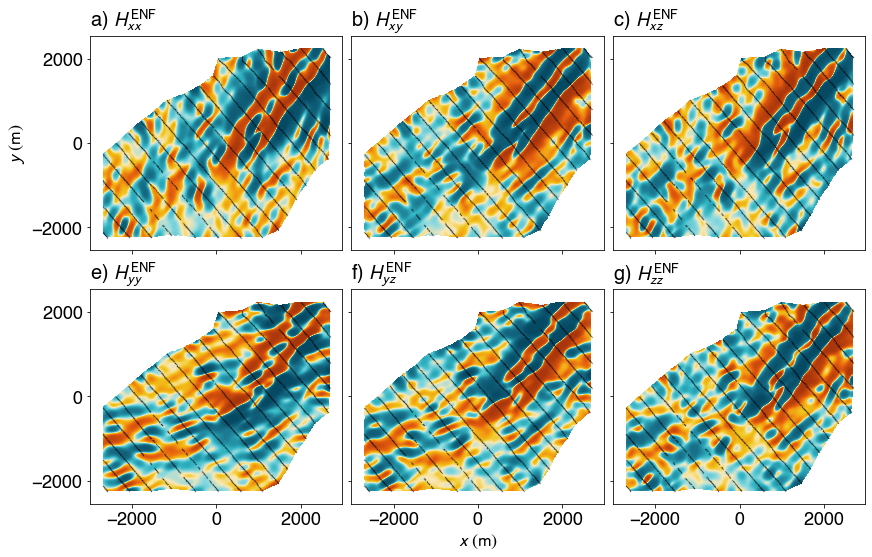

In [15]:
# Plot the NF!
fig, ax = plt.subplots(2, 3, figsize=(12, 8), layout="compressed", sharex=True, sharey=True)
ax = ax.ravel()
plot_labels = ["a) ", "b) ", "c) ", "e) ", "f) ", "g) "]

# Contour plots
for i in range(6):
    ax[i].contourf(
        x_mesh, y_mesh, tw.hist_equalize(enf_grid[:, i].reshape(xx.shape)),
        levels=np.linspace(0, 1, 100),
        extend="both", cmap=curlew_cont
    )
    ax[i].set_title(plot_labels[i] + enf_labels[i], loc="left", pad=10)

# Axis labels and aspect ratio
ax[0].set_ylabel(r"$y\ (\mathrm{m})$")
ax[4].set_xlabel(r"$x\ (\mathrm{m})$")
for a in ax:
    a.set_aspect("equal")
    
# Optionally overlay known points for context
_ = [a_.scatter(xyz[:, 0], xyz[:, 1], s=0.1, c='k', alpha=0.5) for a_ in ax]

plt.show()

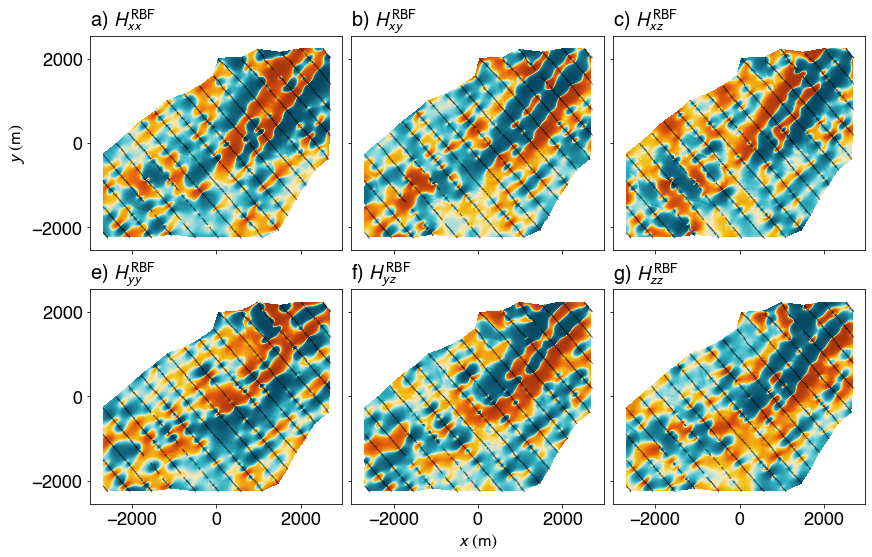

In [16]:
# Plot the RBF!
fig, ax = plt.subplots(2, 3, figsize=(12, 8), layout="compressed", sharex=True, sharey=True)
ax = ax.ravel()
plot_labels = ["a) ", "b) ", "c) ", "e) ", "f) ", "g) "]

# Contour plots
for i in range(6):
    ax[i].contourf(
        x_mesh, y_mesh, tw.hist_equalize(rbf_grid[:, i].reshape(xx.shape)),
        levels=np.linspace(0, 1, 100),
        extend="both", cmap=curlew_cont
    )
    ax[i].set_title(plot_labels[i] + rbf_labels[i], loc="left", pad=10)

# Axis labels and aspect ratio
ax[0].set_ylabel(r"$y\ (\mathrm{m})$")
ax[4].set_xlabel(r"$x\ (\mathrm{m})$")
for a in ax:
    a.set_aspect("equal")
    
# Optionally overlay known points for context
_ = [a_.scatter(xyz[:, 0], xyz[:, 1], s=0.1, c='k', alpha=0.5) for a_ in ax]

plt.show()

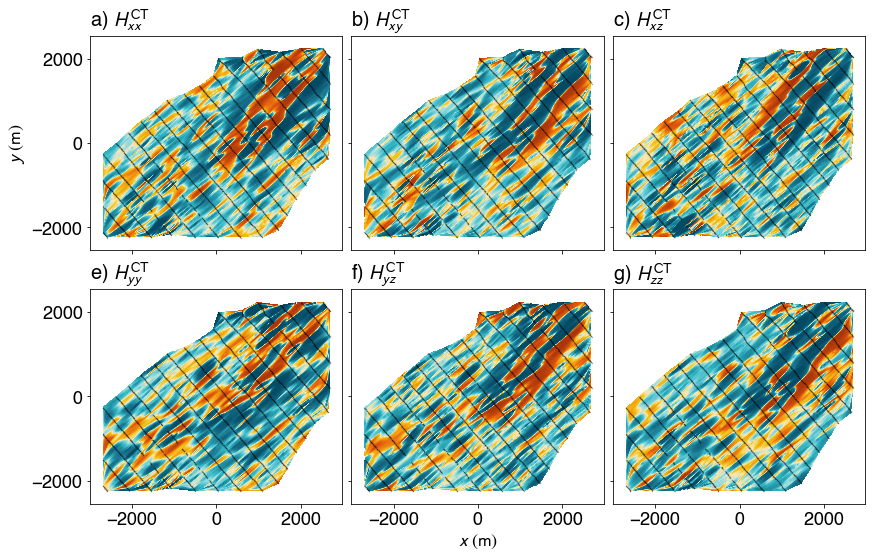

In [17]:
# Plot the CT!
fig, ax = plt.subplots(2, 3, figsize=(12, 8), layout="compressed", sharex=True, sharey=True)
ax = ax.ravel()
plot_labels = ["a) ", "b) ", "c) ", "e) ", "f) ", "g) "]

# Contour plots
for i in range(6):
    ax[i].contourf(
        x_mesh, y_mesh, tw.hist_equalize(ct_grid[:, i].reshape(xx.shape)),
        levels=np.linspace(0, 1, 100),
        extend="both", cmap=curlew_cont
    )
    ax[i].set_title(plot_labels[i] + ct_labels[i], loc="left", pad=10)

# Axis labels and aspect ratio
ax[0].set_ylabel(r"$y\ (\mathrm{m})$")
ax[4].set_xlabel(r"$x\ (\mathrm{m})$")
for a in ax:
    a.set_aspect("equal")
    
# Optionally overlay known points for context
_ = [a_.scatter(xyz[:, 0], xyz[:, 1], s=0.1, c='k', alpha=0.5) for a_ in ax]

plt.show()

In [18]:
# Predict on the test lines
# Neural Field
enf_test_hessians = ens.predict(coords=xyz_test,
                                output="hessian",
                                return_std=True,
                                return_quantiles=(0.05, 0.95)
                               )[0].reshape(-1, 9)[:, (0, 1, 2, 4, 5, -1)]
# RBF
rbf_test_hessians = rbf_func(xyz_test[:, :-1])
# Clough-Tocher
ct_test_hessians = ct_func(xyz_test[:, :-1])

In [19]:
# For comparison, let's get the predictions for individual models
nf_test_hessians = []
for m in ens.members:
    nf_test_hessians.append(m.predict(xyz_test, output="hessian", chunk_size=1024).reshape(-1, 9)[:, (0, 1, 2, 4, 5, -1)])

In [20]:
# Accuracy metrics
from sklearn.metrics import r2_score, mean_squared_error
from skimage.metrics import structural_similarity as ssim

# RBF
rbf_r2 = np.array([r2_score(ftg_test[:, k], rbf_test_hessians[:, k]) for k in range(6)])
norm_rbf_r2 = np.linalg.norm(rbf_r2)/ np.sqrt(6)  # Normalized R2 score
rbf_mse = np.array([mean_squared_error(ftg_test[:, k], rbf_test_hessians[:, k]) for k in range(6)])
norm_rbf_mse = np.linalg.norm(rbf_mse)/ np.sqrt(6)  # Normalized MSE

# Tensorweave
enf_r2 = np.array([r2_score(ftg_test[:, k], enf_test_hessians[:, k]) for k in range(6)])
norm_enf_r2 = np.linalg.norm(enf_r2)/ np.sqrt(6)  # Normalized R2 score
enf_mse = np.array([mean_squared_error(ftg_test[:, k], enf_test_hessians[:, k]) for k in range(6)])
norm_enf_mse = np.linalg.norm(enf_mse)/ np.sqrt(6)  # Normalized MSE

# Compute the R2 for every individual prediction
nf_r2 = []
nf_mse = []
for i in range (len(nf_test_hessians)):
    nf_r2.append(np.array([r2_score(ftg_test[:, k], nf_test_hessians[i][:, k]) for k in range(6)]))
    nf_mse.append(np.array([mean_squared_error(ftg_test[:, k], nf_test_hessians[i][:, k]) for k in range(6)]))

In [25]:
# Convert to NumPy arrays
nf_r2 = np.array(nf_r2)
nf_mse = np.array(nf_mse)
# Compute the mean and standard deviation for the components
nf_mean_r2 = np.mean(nf_r2, axis=0)
nf_std_r2 = np.std(nf_r2, axis=0)
nf_mean_mse = np.mean(nf_mse, axis=0)
nf_std_mse = np.std(nf_mse, axis=0)

/home/kamath92/.local/lib/python3.8/site-packages/seaborn/distributions.py:1176: UserWarning: Log scale: values of z <= 0 have been masked
  cset = contour_func(
/home/kamath92/.local/lib/python3.8/site-packages/seaborn/distributions.py:1176: UserWarning: Log scale: values of z <= 0 have been masked
  cset = contour_func(


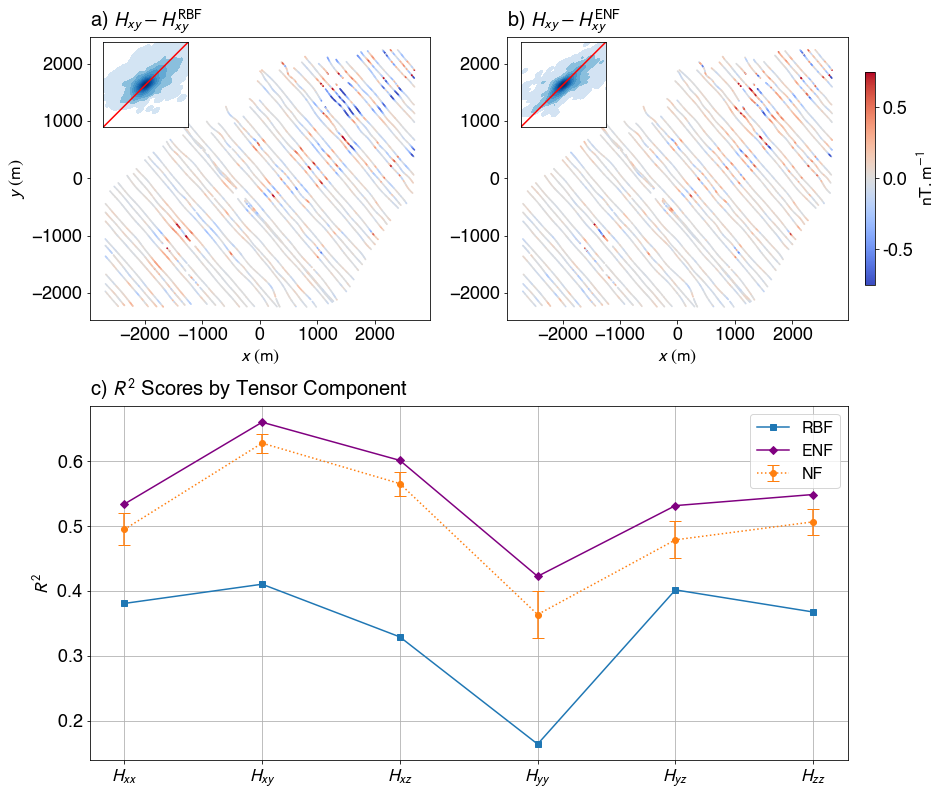

In [26]:
# Plotting the errormaps!
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Plot!
fig, ax_ = plt.subplots(2, 2, figsize=(13, 13), layout="compressed")
gs = ax_[1, 0].get_gridspec()
# remove the underlying Axes
for ax in ax_[1, :]:
    ax.remove()
axbig = fig.add_subplot(gs[1, 0:])

# Component to plot
k = 1
labels = ["a) ", "b) ", "c) "]
to_plot = [rbf_test_hessians[:, k], enf_test_hessians[:, k]]
titles = [r"$H_{xy} - H^{\mathrm{RBF}}_{xy}$", r"$H_{xy} - H^{\mathrm{ENF}}_{xy}$"]
ll = np.nanpercentile(np.abs(ftg_test[:, k] - to_plot[0]), 99)

for i in range(3):
    
    if i == 2:
        ax = axbig
        # Component Names
        components = [r"$H_{xx}$", r"$H_{xy}$", r"$H_{xz}$", 
                      r"$H_{yy}$", r"$H_{yz}$", r"$H_{zz}$"]

        x = range(len(components))
        # RBF Scores
        ax.plot(x, rbf_r2, label="RBF", marker='s')
        # Scores from Individual NF models
        ax.errorbar(x, nf_mean_r2, yerr=nf_std_r2,
                    label="NF", linestyle="dotted", marker="o", capsize=6)
        # ENF Scores
        ax.plot(x, enf_r2, label="ENF", marker='D', c="purple")
        # Beautify!
        ax.set_xticks(x, components)
        ax.set_ylabel(r"$R^2$")
        ax.set_title(labels[i] + r"$R^2$ Scores by Tensor Component", pad=10, loc="left")
        ax.legend(fontsize=16)
        ax.grid(True)
    
    else:
        ax = ax_.ravel()[i]
        
        m = ax.scatter(xyz_test[:, 0], xyz_test[:, 1], s=0.5, c=(ftg_test[:, k] - to_plot[i]), vmin=-ll, vmax=ll, cmap="coolwarm")#, norm=colors.SymLogNorm(0.05))
        ax.set_aspect("equal")
        newaxes = inset_axes(ax, width="30%", height="30%", loc=2)
        sns.kdeplot(x=ftg_test[:, k], y=to_plot[i], ax=newaxes, fill=True, thresh=1e-3, levels=20, cmap="Blues", norm=mcolors.LogNorm())
        newaxes.axline((0, 0), slope=1, c="r")
        newaxes.set_xticks([])
        newaxes.set_yticks([])
        newaxes.set_aspect("equal")
        newaxes.set_xlim([-1, 1])
        newaxes.set_ylim([-1, 1])

        if i == 1:
            cbar = plt.colorbar(mappable=m, orientation="vertical", format="%.1f", shrink=0.6, pad=0.05, label=r"$\mathrm{nT\, m^{-1}}$")
            
        ax.set_title(labels[i] + titles[i], loc="left")
        ax.set_xlabel(r"$x\ (\mathrm{m})$")
        if i == 0:
            ax.set_ylabel(r"$y\ (\mathrm{m})$")

plt.savefig("./Figures/geyer_errormap.png", dpi=350)    
plt.show()